In [ ]:
!pip install tensorflow==2.12

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
from PIL import Image
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import albumentations as A
import matplotlib.pyplot as plt
import sys
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, InputLayer, PReLU, Activation
from tensorflow.keras import initializers

In [ ]:
IMAGE_FORMAT = ".png"
DOWNSAMPLE_MODE = Image.BICUBIC
COLOR_CHANNELS = 3

HR_IMG_SIZE = (648, 648)
UPSCALING_FACTOR = 4
LR_IMG_SIZE = (HR_IMG_SIZE[0] // UPSCALING_FACTOR, HR_IMG_SIZE[1] // UPSCALING_FACTOR)


class DIV2K_Dataset(keras.utils.Sequence):

    def __init__(self, hr_image_folder: str, batch_size: int, set_type: str):
        self.batch_size = batch_size
        self.hr_image_folder = hr_image_folder
        self.image_fns = np.sort([
            x for x in os.listdir(hr_image_folder) if x.endswith(IMAGE_FORMAT)
        ])

        if set_type == "train":
            self.image_fns = self.image_fns[:-200]
        elif set_type == "val":
            self.image_fns = self.image_fns[-200:-100]
        else:
            self.image_fns = self.image_fns[-100:]

        if set_type in ["train", "val"]:
            self.transform = A.Compose(
                [
                    A.RandomCrop(width=HR_IMG_SIZE[0], height=HR_IMG_SIZE[1], p=1.0),
                    A.HorizontalFlip(p=0.5),
                    A.ColorJitter(
                        brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.8
                    ),
                ]
            )
        else:
            self.transform = A.Compose(
                [
                    A.RandomCrop(width=HR_IMG_SIZE[0], height=HR_IMG_SIZE[1], p=1.0),
                ]
            )

        self.to_float = A.ToFloat(max_value=255)

    def __len__(self):
        return len(self.image_fns) // self.batch_size

    def on_epoch_end(self):
        random.shuffle(self.image_fns)

    def __getitem__(self, idx):
        """Returns a batch of samples"""
        i = idx * self.batch_size
        batch_image_fns = self.image_fns[i : i + self.batch_size]
        batch_hr_images = np.zeros((self.batch_size,) + HR_IMG_SIZE + (COLOR_CHANNELS,))
        batch_lr_images = np.zeros((self.batch_size,) + LR_IMG_SIZE + (COLOR_CHANNELS,))

        for i, image_fn in enumerate(batch_image_fns):
            hr_image_pil = Image.open(os.path.join(self.hr_image_folder, image_fn))
            hr_image = np.array(hr_image_pil)

            hr_image_transform = self.transform(image=hr_image)["image"]
            hr_image_transform_pil = Image.fromarray(hr_image_transform)
            lr_image_transform_pil = hr_image_transform_pil.resize(
                LR_IMG_SIZE, resample=DOWNSAMPLE_MODE
            )
            lr_image_transform = np.array(lr_image_transform_pil)

            batch_hr_images[i] = self.to_float(image=hr_image_transform)["image"]
            batch_lr_images[i] = self.to_float(image=lr_image_transform)["image"]

        return (batch_lr_images, batch_hr_images)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def create_model(
    d: int,
    s: int,
    m: int,
    input_size: tuple = LR_IMG_SIZE,
    upscaling_factor: int = UPSCALING_FACTOR,
    color_channels: int = COLOR_CHANNELS,
):

    model = Sequential()
    model.add(InputLayer(input_shape=(input_size[0], input_size[1], color_channels)))

    # feature extraction
    model.add(
        Conv2D(
            kernel_size=5,
            filters=d,
            padding="same",
            kernel_initializer=initializers.HeNormal(),
        )
    )
    model.add(PReLU(alpha_initializer="zeros", shared_axes=[1, 2]))

    # shrinking
    model.add(
        Conv2D(
            kernel_size=1,
            filters=s,
            padding="same",
            kernel_initializer=initializers.HeNormal(),
        )
    )
    model.add(PReLU(alpha_initializer="zeros", shared_axes=[1, 2]))

    # mapping
    for _ in range(m):
        model.add(
            Conv2D(
                kernel_size=3,
                filters=s,
                padding="same",
                kernel_initializer=initializers.HeNormal(),
            )
        )
        model.add(PReLU(alpha_initializer="zeros", shared_axes=[1, 2]))

    # expanding
    model.add(Conv2D(kernel_size=1, filters=d, padding="same"))
    model.add(PReLU(alpha_initializer="zeros", shared_axes=[1, 2]))

    # deconvolution
    model.add(
        Conv2DTranspose(
            kernel_size=9,
            filters=color_channels,
            strides=upscaling_factor,
            padding="same",
            kernel_initializer=initializers.RandomNormal(mean=0, stddev=0.001),
        )
    )

    return model

In [ ]:
config = {
    "data_path": "/content/drive/MyDrive/DIV2K_train_valid_HR",
    "model_d": 56,
    "model_s": 12,
    "model_m": 4,
    "lr_init": 0.001,
    "epochs": 500,
    "batch_size": 30,
    "steps_per_epoch": 20,
    "val_batch_size": 20,
    "validation_steps": 4,
    "weights_fn": "weights/model_{epoch:05d}.h5",
}

model = keras.models.load_model("/content/model_00277.h5")

In [ ]:
test_dataset = DIV2K_Dataset(
    hr_image_folder=config["data_path"],
    batch_size=config["batch_size"],
    set_type="test",
)

n_runs = 5  # Number of times to loop through the dataset
psnrs = []

for _ in range(n_runs):
    for batch in test_dataset:
        lr_images = batch[0]
        hr_images = batch[1]
        preds = model.predict(lr_images)

        # Calculate PSNR for the batch
        psnr = tf.image.psnr(hr_images, preds, max_val=1.0)
        psnr = psnr.numpy().tolist()
        psnrs.extend(psnr)

print("Mean PSNR: {:.3f}".format(np.mean(psnrs)))

1/1 [==============================] - 5s 5s/step
Mean PSNR: 26.320


1/1 [==============================] - 4s 4s/step


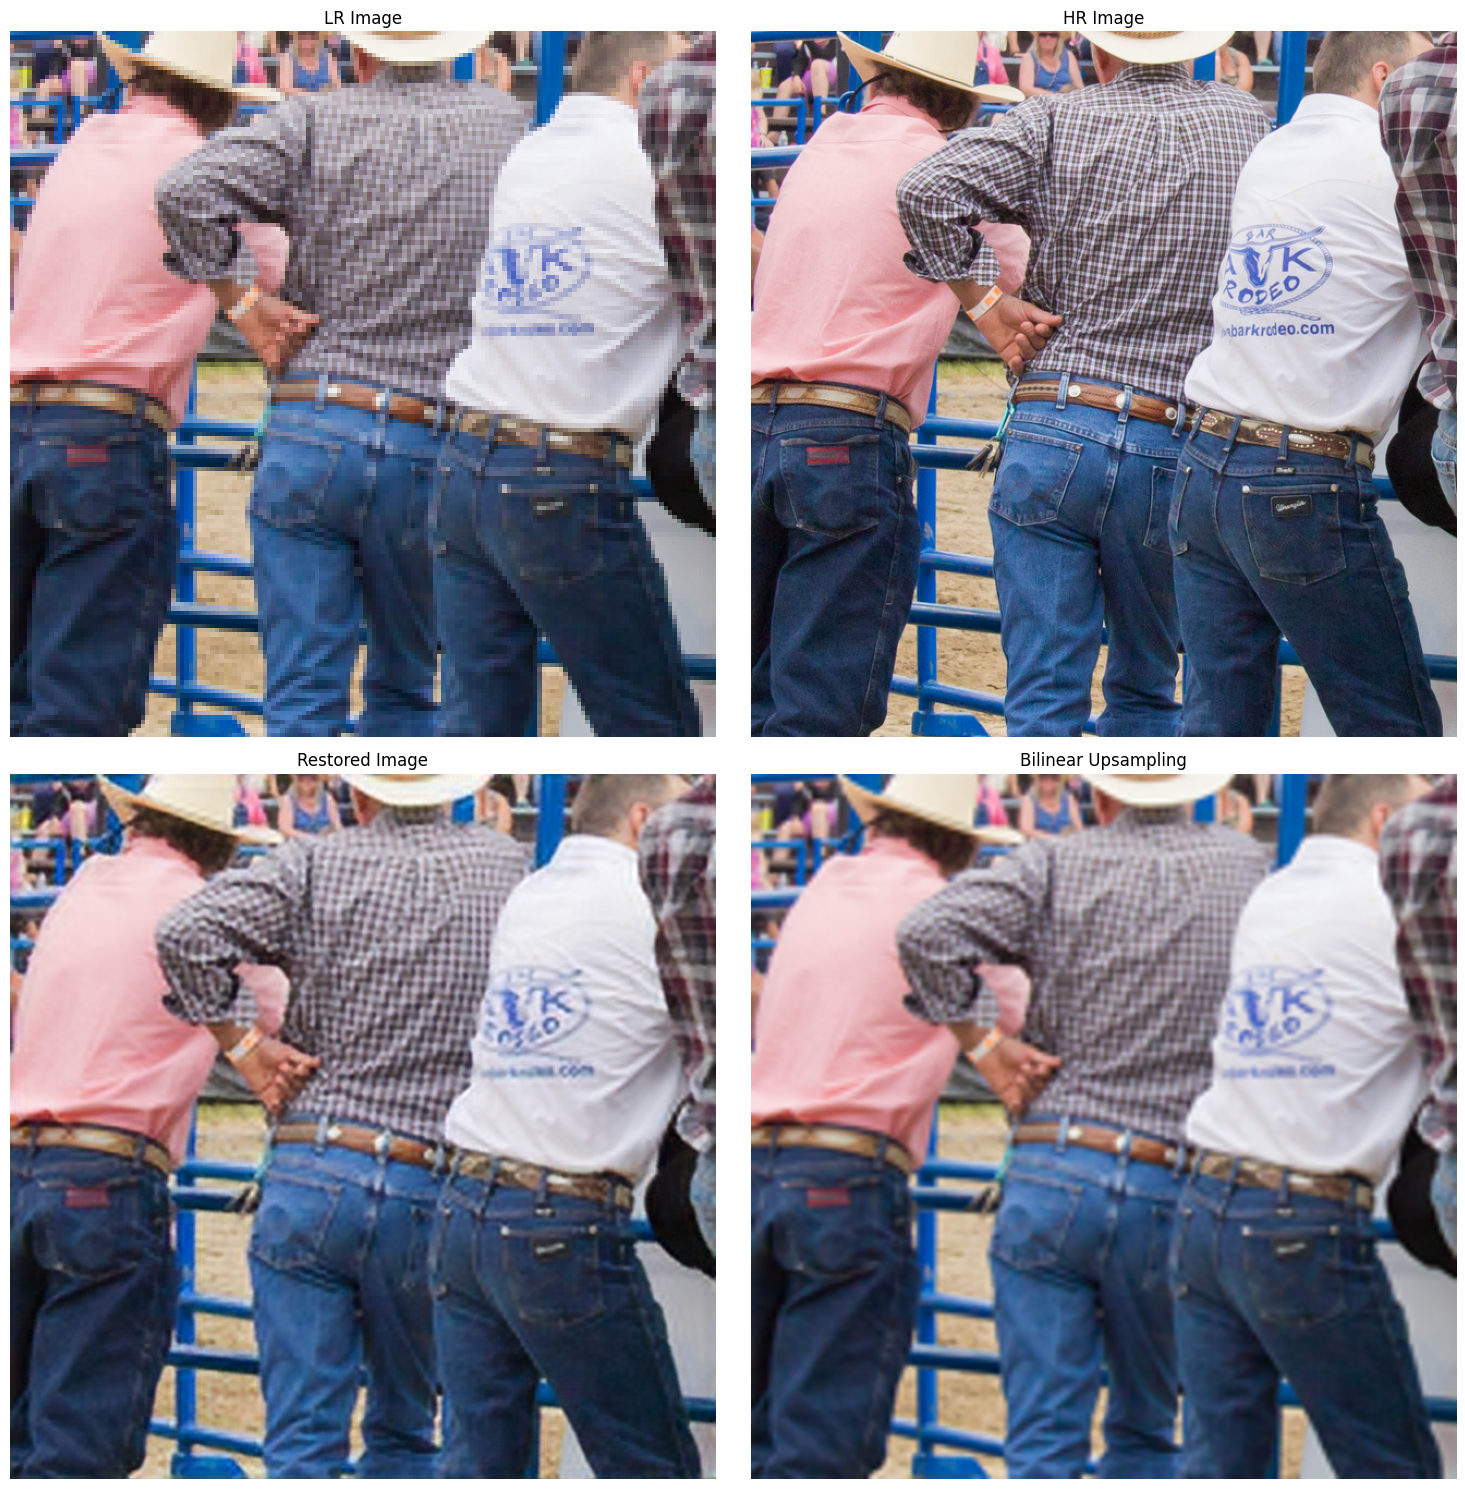

In [ ]:
batch_id = 0
batch = test_dataset.__getitem__(batch_id)
preds = model.predict(batch[0])
img_id = 3

plt.figure(figsize=[15, 15])
plt.subplot(2, 2, 1)
plt.imshow(batch[0][img_id])
plt.axis("off")
plt.title("LR Image")

plt.subplot(2, 2, 2)
plt.imshow(batch[1][img_id])
plt.axis("off")
plt.title("HR Image")

plt.subplot(2, 2, 3)
plt.imshow(preds[img_id])
plt.axis("off")
plt.title("Restored Image")


plt.subplot(2, 2, 4)
lr_image = Image.fromarray(np.array(batch[0][img_id] * 255, dtype="uint8"))
lr_image_resized = lr_image.resize(HR_IMG_SIZE, resample=DOWNSAMPLE_MODE)
plt.imshow(lr_image_resized)
plt.axis("off")
plt.title("Bilinear Upsampling")

plt.tight_layout()
plt.show()

1/1 [==============================] - 3s 3s/step


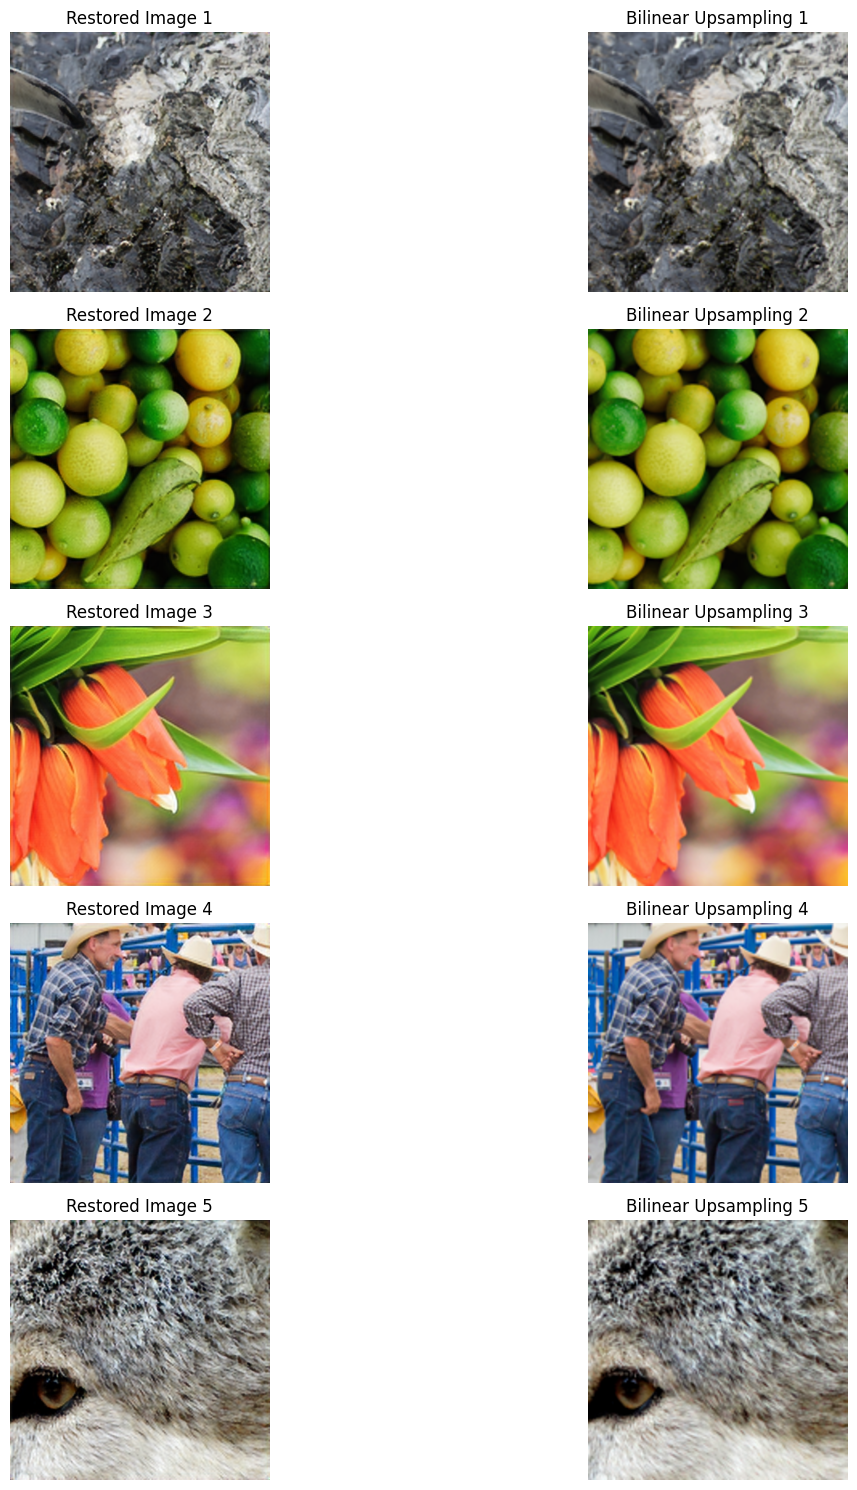

In [ ]:
n_images = 5
batch_id = 0
batch = test_dataset.__getitem__(batch_id)
preds = model.predict(batch[0])

plt.figure(figsize=(15, 3 * n_images))

for i in range(n_images):
    plt.subplot(n_images, 2, 2 * i + 1)
    plt.imshow(preds[i])
    plt.axis("off")
    plt.title(f"Restored Image {i + 1}")

    lr_image = Image.fromarray(np.array(batch[0][i] * 255, dtype="uint8"))
    lr_image_resized = lr_image.resize(HR_IMG_SIZE, resample=DOWNSAMPLE_MODE)
    plt.subplot(n_images, 2, 2 * i + 2)
    plt.imshow(lr_image_resized)
    plt.axis("off")
    plt.title(f"Bilinear Upsampling {i + 1}")

plt.tight_layout()
plt.show()

In [ ]:
save_path = "/content/drive/MyDrive/FSRCNN/Results"

os.makedirs(save_path, exist_ok=True)

n_images = 5
batch_id = 0
batch = test_dataset.__getitem__(batch_id)
preds = model.predict(batch[0])

for i in range(n_images):
    lr_image = Image.fromarray(np.array(batch[0][i] * 255, dtype="uint8"))
    hr_image = Image.fromarray(np.array(batch[1][i] * 255, dtype="uint8"))
    restored_image = Image.fromarray(np.array(preds[i] * 255, dtype="uint8"))
    bilinear_image = lr_image.resize(HR_IMG_SIZE, resample=DOWNSAMPLE_MODE)

    lr_image.save(os.path.join(save_path, f"LR_Image_{i+1}.png"))
    hr_image.save(os.path.join(save_path, f"HR_Image_{i+1}.png"))
    restored_image.save(os.path.join(save_path, f"Restored_Image_{i+1}.png"))
    bilinear_image.save(os.path.join(save_path, f"Bilinear_Image_{i+1}.png"))

print(f"Images saved to {save_path}")

1/1 [==============================] - 3s 3s/step
Images saved to /content/drive/MyDrive/FSRCNN/Results
